In [1]:
'''
This is the Advanced Lane Finding Project. After learning about several computer vision techniques, 
lanes and objects can be more accurately defined by looking at reliable parameters.
For this project, 4 steps are required.
1. Camera Calibration
2. Distortion Correction
3. Color and Gradient Threshold
4. Perspective Transform
Using the first cell to import all relevant libraries.
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

20


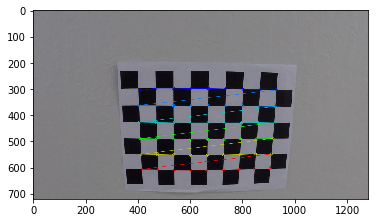

In [2]:
#Starting with Calibration to show a distorted image and then turn into undistorted image

#setting up the object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
objpoints = [] # 3d points in real space
imgpoints = [] # 2d points in image plane.
    
#loading the images in the camera calibration folder into images using the glob function
images = glob.glob('camera_cal/calibration*.jpg')
print(len(images))
    
#iterating through all images to find chess corners in the image plans as well as real world
#space and mapping it out to calibrate the camera through series of shots in different angles.
for idx, image_name in enumerate(images):
    img = mpimg.imread(image_name)
        
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    #finding the chessboard corners in image 
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        #drawing the corners onto image to see if we captured everything correctly
        cv2.drawChessboardCorners(img, (9,6), corners, ret)        
       
        plt.imshow(img)

   
        
for idx, image_name in enumerate(images):
    img = mpimg.imread(image_name)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_size = img.shape[1::-1]
    offset = 100
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:        
        dist = cv2.undistort(img, mtx, dist, None, mtx)       
        src = np.float32([corners[0], corners[9-1], corners[-1], corners[-9]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                [img_size[0]-offset, img_size[1]-offset], 
                [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(dist, M, img_size)
        #uncomment these lines to see undistortion and warping applied to all checkboard pieces
        '''
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(warped)
        ax2.set_title('Undistorted Image and Warped', fontsize=30)   
        '''

In [ ]:
os.listdir("test_images")    
print(dst)

In [ ]:
print(len(imgpoints)/4)
print(imgpoints[0][0], imgpoints[5][0], imgpoints[-5][0], imgpoints[-1][0])

In [3]:
#This is where the manipulations on the image will be done.
#Distortion correction


def warp_image(image):    
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1::-1], None, None)
    dist = cv2.undistort(image, mtx, dist, None, mtx)
    new_src = np.float32([[236,img.shape[0]], [584,img.shape[0]/2 + 100], [692,img.shape[0]/2 + 100], [1061,img.shape[0]]])
    dst = np.float32([[310, img.shape[0]], [310, 0], 
                    [1000, 0], 
                    [1000, img.shape[0]]])
    M = cv2.getPerspectiveTransform(new_src, dst)
    warped = cv2.warpPerspective(dist, M, img_size)
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(warped)
    ax2.set_title('Undistorted Image and Warped', fontsize=30)
    '''
    return ret, mtx, dist, warped

In [39]:
#image = mpimg.imread('problem_pic.jpg')
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxb=np.zeros_like(scaled_sobel)
    sxb[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1        
    return sxb

# Function that handles the HLS channeling
#image_p is image parameter- avoids mixing up names with previously defined image
def process_hls(image_p, thresh=(0, 255), g_thresh = (0,255), h_thresh = (0,255), v_thresh = (0,255), r_thresh = (0,255), y_thresh = (0,255)):
    hls = cv2.cvtColor(image_p, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(image_p, cv2.COLOR_RGB2GRAY)    
    sxb_rgb = np.zeros_like(gray) 
    s = hls[:,:,2] #Taking the 3rd column which is of interest (S Channel)
    l = hls[:,:,1]
    sxb = np.zeros_like(s)
    hsv = cv2.cvtColor(image_p, cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    v = hsv[:,:,2]
    r = image_p[:,:,0]
    g = image_p[:,:,1]
    y = (r & g) #test4.jpg has been properly tested
    condition0 = ((s > thresh[0]) & (s <= thresh[1])) 
    condition1 = ((gray > g_thresh[0]) & (gray <= g_thresh[1])) #bottom part of right lane
    condition2 = ((h > h_thresh[0]) & (h < h_thresh[1])) #captures most of left lane (good) 19,50
    condition3 = ((v > v_thresh[0]) & (v < v_thresh[1])) #most of left lane 215,255
    condition4 = ((r > r_thresh[0]) & (r < r_thresh[1])) # captures entire left lane (test4) 220,255
    #condition5 = ((l > l_thresh[0]) & (l < l_thresh[1])) #mainly gets part of right lane 200,255
    condition6 = ((y > y_thresh[0]) & (y < y_thresh[1])) #combining red and green to capture yellow lane (left lane) 200,255
    #applying multiple thresholds so that overall can capture the best of the R and S binary channels.
    combo = condition0 | condition1 | condition2 | condition3 | condition4 | condition6
    sxb[combo] = 1 #creating a binary array
    return sxb

#directional gradient thresholding
def dir_threshold(img, sobel_kernel=15, thresh=(0, np.pi/2)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    angle = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxb = np.zeros_like(angle)
    sxb[(angle >= thresh[0]) & (angle <=  thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    
    return sxb

def combined_binary_mask(image, ksize, mag_low, mag_high, dir_low, dir_high, s_low, s_high, g_low, g_high, h_low, h_high, v_low, v_high, r_low, r_high, y_low, y_high):
    grad_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(mag_low,mag_high))
    hls_binary = process_hls(image, thresh = (s_low, s_high), g_thresh = (g_low,g_high), h_thresh = (h_low,h_high), v_thresh = (v_low,v_high), r_thresh = (r_low,r_high), y_thresh = (y_low,y_high))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(dir_low, dir_high))
    #print(dist)
    combined_binary = ((hls_binary == 1) | (grad_binary == 1) | (dir_binary == 1))    
    
    return combined_binary

'''
#image = mpimg.imread('test_images/test5.jpg')
ret, mtx, dist, wrp  = warp_image(image)
grad_binary = abs_sobel_thresh(wrp, orient='x', sobel_kernel=15, thresh=(40,100))
hls_binary = process_hls(wrp, thresh = (240, 250), g_thresh = (205,255))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
#print(dist)
combined_binary = ((hls_binary == 1) | (grad_binary == 1))
'''
'''
global left_fit 
left_fit = np.array([0, 0, 0], dtype=np.float32)
global right_fit 
right_fit = np.array([0, 0 ,0], dtype=np.float32)
# Plot the result
'''

'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image_f)
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''


"\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(image_f)\nax2.set_title('Thresholded S', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

In [44]:
#function to test interactive parameters
def interactive_mask(ksize, mag_low, mag_high, dir_low, dir_high, s_low, s_high, g_low, g_high, h_low, h_high, v_low, v_high, r_low, r_high, y_low, y_high):
    image_l = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_chan, a_chan, b_chan = cv2.split(image_l)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_chan)
    m_chan = cv2.merge((cl, a_chan, b_chan))
    image_f = cv2.cvtColor(m_chan, cv2.COLOR_LAB2RGB)
    combined = combined_binary_mask(image_f, ksize, mag_low, mag_high, dir_low, dir_high,\
                                    s_low, s_high, g_low, g_high, h_low, h_high, v_low, v_high, r_low, r_high, y_low, y_high)
    plt.figure(figsize=(10,10))
    plt.imshow(combined,cmap='gray')

interact(interactive_mask, ksize=(1,31,2), mag_low=(0,255), mag_high=(0,255),\
         dir_low=(0, np.pi/2), dir_high=(0, np.pi/2), s_low=(0,255),\
         s_high=(0,255), g_low=(0,255), g_high=(0,255), h_low=(0,255), h_high=(0,255), v_low=(0,255), v_high=(0,255), r_low=(0,255), r_high=(0,255), l_low=(0,255), l_high=(0,255), y_low=(0,255), y_high=(0,255))

interactive(children=(IntSlider(value=15, description='ksize', max=31, min=1, step=2), IntSlider(value=127, description='mag_low', max=255), IntSlider(value=127, description='mag_high', max=255), FloatSlider(value=0.7853981633974483, description='dir_low', max=1.5707963267948966), FloatSlider(value=0.7853981633974483, description='dir_high', max=1.5707963267948966), IntSlider(value=127, description='s_low', max=255), IntSlider(value=127, description='s_high', max=255), IntSlider(value=127, description='g_low', max=255), IntSlider(value=127, description='g_high', max=255), IntSlider(value=127, description='h_low', max=255), IntSlider(value=127, description='h_high', max=255), IntSlider(value=127, description='v_low', max=255), IntSlider(value=127, description='v_high', max=255), IntSlider(value=127, description='r_low', max=255), IntSlider(value=127, description='r_high', max=255), IntSlider(value=127, description='y_low', max=255), IntSlider(value=127, description='y_high', max=255), Output()), _dom_classes=('widget-interact',))

<function __main__.interactive_mask(ksize, mag_low, mag_high, dir_low, dir_high, s_low, s_high, g_low, g_high, h_low, h_high, v_low, v_high, r_low, r_high, y_low, y_high)>

In [60]:
#Sliding windows function that will determine the polynomial 
#binary_warped = combined_binary
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[0:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(leftx_base, rightx_base, midpoint)
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    #print(leftx)
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    func_left = np.polyfit(ploty, left_fitx, 2)
    func_right = np.polyfit(ploty, right_fitx, 2)
    return func_left, func_right, ploty

#left_fit = np.array([0, 0, 0])
#right_fit = np.array([0, 0 ,0]) 
#out_img, left_fit, right_fit, ploty = fit_polynomial(combined_binary)
#print(left_fit, right_fit)
#print(left_fit)
#plt.imshow(out_img)
#print(left_fit[0])


In [16]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
        
    left_fit = np.polyfit(lefty, leftx, 2) #
    right_fit = np.polyfit(righty, rightx, 2) #
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
                
   
    
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


In [17]:
def search_around(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox >= left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin/4) &  
                        (nonzerox < left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))
    right_lane_inds = ((nonzerox >= right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin) &  
                        (nonzerox < right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin/4))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print(leftx[0], rightx[0])
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.uint8)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin/4, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+7*margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-4*margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin/4, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return window_img, out_img, leftx[0], rightx[0]

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#result, window_img, out_img = search_around(combined_binary, left_fit, right_fit)

# View your output
#plt.imshow(result)

In [76]:
def measure_curvature_real(ploty, left_fit, right_fit, x_left, x_right, image):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])   ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    ll_b = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    rl_b = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    lane_width = (ll_b + rl_b) // 2
    vehicle_center = image.shape[1]//2
    
    lane_width_cr = lane_width*xm_per_pix
    
    vehicle_center_cr = vehicle_center*xm_per_pix
    
    center = lane_width_cr - vehicle_center_cr 
    
    
    return left_curverad, right_curverad, center


# Calculate the radius of curvature in meters for both lane lines
#left_curverad, right_curverad = measure_curvature_real()

#print(left_curverad, 'm', right_curverad, 'm')

In [19]:
def invert_back(window_img, out_img, image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
    weight = cv2.addWeighted(out_img, 0.3, window_img, 0.3, 0)
    new_src = np.float32([[236,img.shape[0]], [584,img.shape[0]/2 + 100], [692,img.shape[0]/2 + 100], [1061,img.shape[0]]])
    dst = np.float32([[310, img.shape[0]], [310, 0], 
                    [1000, 0], 
                    [1000, img.shape[0]]])
    Minv = cv2.getPerspectiveTransform(dst, new_src)
    
    unwarped = cv2.warpPerspective(weight, Minv, img_size)
    final_unwarped = cv2.addWeighted(image, 1, unwarped, 1, 0)
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(final_unwarped)
    ax2.set_title('Undistorted Image and Warped', fontsize=30)  
    '''
    return final_unwarped

#final_result = invert_back(window_img, out_img)



In [77]:
def advanced_lane_pipeline(image):
    #This function is the main function which calls upon all the above tested functions.
    #Part 1
    '''
    image_l = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_chan, a_chan, b_chan = cv2.split(image_l)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_chan)
    m_chan = cv2.merge((cl, a_chan, b_chan))
    image_f = cv2.cvtColor(m_chan, cv2.COLOR_LAB2RGB)
    '''
    ret, mtx, dist, wrp  = warp_image(image)
    combined_binary = combined_binary_mask(wrp, ksize=15, mag_low=40, mag_high=100, dir_low=0.80, dir_high=0.80,\
                                    s_low=240, s_high=250, g_low=198, g_high=200, h_low=20, h_high=25, v_low=215, v_high=220, r_low=215, r_high=220, y_low=210, y_high=255)
    
    # Plot the result
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(wrp)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined_binary, cmap='gray')
    ax2.set_title('Thresholded S', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    '''
    
    #Part 2
    binary_warped = combined_binary
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fit, right_fit, ploty = fit_polynomial(binary_warped)
    #left_fit and right_fit become region of interest
        
    #Part 3
    window_img, out_img, left_c, right_c = search_around(binary_warped, left_fit, right_fit)
    
    font = cv2.FONT_ITALIC
    topCenter = (image.shape[1]//4, 45)
    top = (image.shape[1]//4, 95)
    fontScale = 1
    fontColor = (255,0,0)
    lineType = 2
    
    #Part 4
    left_curverad, right_curverad, center = measure_curvature_real(ploty, left_fit, right_fit, left_c, right_c, image)
    
    #Part 5
    final_result = invert_back(window_img, out_img, image)
    if (center < 0):        
        cv2.putText(final_result, 'Curvature is '+ left_curverad.astype(str) + ' [m]', top, font, fontScale, fontColor, lineType, cv2.LINE_AA)
        cv2.putText(final_result, 'Car is '+ np.absolute(center).astype(str) + ' [m] left of lane', topCenter, font, fontScale, fontColor, lineType, cv2.LINE_AA)
    else:        
        cv2.putText(final_result, 'Curvature is '+ right_curverad.astype(str) + ' [m]', top, font, fontScale, fontColor, lineType, cv2.LINE_AA)
        cv2.putText(final_result, 'Car is '+ np.absolute(center).astype(str) + ' [m] right of lane', topCenter, font, fontScale, fontColor, lineType, cv2.LINE_AA)
    
    return final_result

    

In [80]:
test_video_1 = 'chand_project.mp4'
clip1 = VideoFileClip("project_video.mp4")
#.subclip(38,42)
test_clip1 = clip1.fl_image(advanced_lane_pipeline)
%time test_clip1.write_videofile(test_video_1, audio=False)

[MoviePy] >>>> Building video chand_project.mp4
[MoviePy] Writing video chand_project.mp4


100%|█████████▉| 1260/1261 [27:22<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: chand_project.mp4 

CPU times: user 24min 45s, sys: 25.4 s, total: 25min 10s
Wall time: 27min 25s


In [81]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_1))